 Setup: Install Dependencies and Import Libraries
  ( Установка зависимостей и импорт библиотек)

In [3]:
!pip install cupy-cuda12x opencv-python matplotlib

import time
import cupy as cp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

print(cp.__version__)
print(f"CUDA runtime version: {cp.cuda.runtime.runtimeGetVersion()}")
print(f"CUDA driver version: {cp.cuda.runtime.driverGetVersion()}")
!nvcc --version


13.3.0
CUDA runtime version: 12060
CUDA driver version: 12040
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


 Upload Your Video to Colab

In [6]:
#!apt-get update
#!apt-get install -y ffmpeg
#!ffmpeg -i /content/drive/MyDrive/lab2.mov /content/drive/MyDrive/converted_file.mp4
# Upload your input video file
input_video_path = '/content/drive/MyDrive/converted_file.mp4'

In [7]:
print(f"Video found: {input_video_path}")

Video found: /content/drive/MyDrive/converted_file.mp4


 CUDA Implementation (2D Blocks + Threads)

In [8]:
!nvidia-smi

Tue May 27 02:05:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using CUDA GPU: b'Tesla T4'
Running CUDA Emboss + Downscale benchmark (GPU-only)...
Run 1: 116702.26 ms
Run 2: 109679.71 ms
Run 3: 114648.12 ms
Average Time: 113676.70 ms


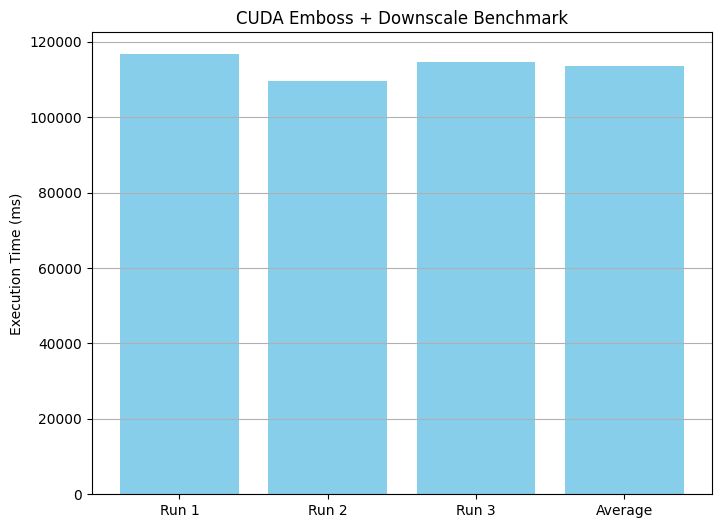

Visualization saved at: /content/output/lab2_cuda/execution_times.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:

import os


# CUDA Kernel
kernel_code = r'''
extern "C" __global__
void emboss_downsample_2d(const float* in_img, float* out_img, int W, int H) {
    int out_x = blockIdx.x * blockDim.x + threadIdx.x;
    int out_y = blockIdx.y * blockDim.y + threadIdx.y;
    if (out_x >= W/2 || out_y >= H/2) return;
    const float k[3][3] = {{-2,-1,0},{-1,1,1},{0,1,2}};
    int ix = 2*out_x, iy = 2*out_y;
    for (int c=0; c<3; c++) {
        float sum=0;
        for(int dy=-1; dy<=1; dy++)
            for(int dx=-1; dx<=1; dx++) {
                int sx = min(max(ix+dx,0),W-1);
                int sy = min(max(iy+dy,0),H-1);
                sum += in_img[(sy*W+sx)*3+c] * k[dy+1][dx+1];
            }
        out_img[(out_y*(W/2)+out_x)*3+c] = sum;
    }
}
'''

def run_cuda(input_video_path , output_path, kernel):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video file: {input_video_path }")
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width//2, height//2))

    start = time.time()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img = frame.astype(np.float32)
        d_img = cp.array(img)
        d_out = cp.zeros((height//2, width//2, 3), dtype=cp.float32)
        threads = (16, 16)
        blocks = ((width//2+threads[0]-1)//threads[0], (height//2+threads[1]-1)//threads[1])
        kernel(blocks, threads, (d_img, d_out, width, height))
        out_frame = cp.asnumpy(d_out).clip(0,255).astype(np.uint8)
        out_writer.write(out_frame)
    cap.release()
    out_writer.release()
    return (time.time() - start) * 1000

# Set output directory in Colab
from google.colab import drive, files
drive.mount('/content/drive')

output_dir = '/content/output/lab2_cuda'
os.makedirs(output_dir, exist_ok=True)

# Check CUDA GPU
if cp.cuda.runtime.getDeviceCount() == 0:
    print("No CUDA-compatible GPU found! This lab requires CUDA. Exiting.")
else:
    print(f"Using CUDA GPU: {cp.cuda.runtime.getDeviceProperties(0)['name']}")


    kernel = cp.RawKernel(kernel_code, 'emboss_downsample_2d')

    times = []
    print("Running CUDA Emboss + Downscale benchmark (GPU-only)...")
    for i in range(3):
        output_path = os.path.join(output_dir, f'output_run{i+1}.mp4')
        t = run_cuda(input_video_path, output_path, kernel)
        times.append(t)
        print(f"Run {i+1}: {t:.2f} ms")

    avg_time = sum(times)/3
    print(f"Average Time: {avg_time:.2f} ms")

    # Save execution time visualization
    plt.figure(figsize=(8,6))
    x_labels = ['Run 1', 'Run 2', 'Run 3', 'Average']
    y_values = times + [avg_time]
    plt.bar(x_labels, y_values, color='skyblue')
    plt.ylabel('Execution Time (ms)')
    plt.title('CUDA Emboss + Downscale Benchmark')
    plt.grid(axis='y')
    plt_path = os.path.join(output_dir, 'execution_times.png')
    plt.savefig(plt_path)
    plt.show()
    print(f"Visualization saved at: {plt_path}")

    # Download output files
   # for file in os.listdir(output_dir):
        #files.download(os.path.join(output_dir, file))
